In [1]:
import xarray as xr
import geopandas as gpd
from rasterio.plot import show
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import cv2 as cv
from matplotlib import pyplot as plt
import skimage.color
import skimage.transform
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
rgb_f = 'E:/data/imagery/CPER_UAS_2021June/products/mavic_flights_20210602/cper_day1_200ft_ortho_UTM.tif'
hillshade_f = 'E:/data/imagery/CPER_UAS_2021June/products/mavic_flights_20210602/cper_day1_200ft_hillshade_clip_UTM.tif'
roi_f = 'pdog_test_poly.shp'
window_size_m = 15
num_windows = 24

In [3]:
xr_rgb = xr.open_rasterio(rgb_f).isel(band=slice(0, 3))
xr_hillshade = xr.open_rasterio(hillshade_f)
roi = gpd.read_file(roi_f)
BBox = roi.total_bounds
xr_rgb = xr_rgb.sel(y=xr_rgb.y[(xr_rgb.y >= BBox[1]) & (xr_rgb.y <= BBox[3])],
           x=xr_rgb.x[(xr_rgb.x >= BBox[0]) & (xr_rgb.x <= BBox[2])])
xr_hillshade = xr_hillshade.sel(y=xr_hillshade.y[(xr_hillshade.y >= BBox[1]) & (xr_hillshade.y <= BBox[3])],
           x=xr_hillshade.x[(xr_hillshade.x >= BBox[0]) & (xr_hillshade.x <= BBox[2])])
#display(xr_rgb)
#display(xr_hillshade)

In [4]:
y_starts = np.arange(xr_hillshade.y.max(), xr_hillshade.y.min(), -window_size_m)
x_starts = np.arange(xr_hillshade.x.min(), xr_hillshade.x.max(), window_size_m)
y_starts_sub = np.random.choice(y_starts, size=num_windows)
x_starts_sub = np.random.choice(x_starts, size=num_windows)

In [5]:
for y_start, x_start in zip(y_starts_sub, x_starts_sub):
    print(y_start, x_start)
    xr_hillshade_crop = xr_hillshade.sel(y=slice(y_start, 
                                                 y_start - np.floor(
                                                     1/xr_hillshade.res[0]*window_size_m*xr_hillshade.res[0])), 
                                     x=slice(x_start,
                                             x_start + np.floor(
                                                 1/xr_hillshade.res[0]*window_size_m*xr_hillshade.res[1])))
    xr_rgb_crop = xr_rgb.sel(y=xr_rgb.y[(xr_rgb.y >= xr_hillshade_crop.y.min()) & (xr_rgb.y <= xr_hillshade_crop.y.max())],
               x=xr_rgb.x[(xr_rgb.x >= xr_hillshade_crop.x.min()) & (xr_rgb.x <= xr_hillshade_crop.x.max())])

4516646.4011104535 519880.6572879066
4516841.4011104535 519940.6572879066
4516961.4011104535 519850.6572879066
4516856.4011104535 519850.6572879066
4516631.4011104535 519880.6572879066
4516616.4011104535 519925.6572879066
4516946.4011104535 519955.6572879066
4516676.4011104535 519955.6572879066
4516676.4011104535 519835.6572879066
4516721.4011104535 519910.6572879066
4516736.4011104535 519970.6572879066
4516646.4011104535 519985.6572879066
4517006.4011104535 519910.6572879066
4516721.4011104535 519820.6572879066
4516976.4011104535 519895.6572879066
4516691.4011104535 519820.6572879066
4516616.4011104535 519955.6572879066
4517036.4011104535 519880.6572879066
4516976.4011104535 519880.6572879066
4516976.4011104535 519895.6572879066
4516901.4011104535 519835.6572879066
4516796.4011104535 519940.6572879066
4516706.4011104535 519955.6572879066
4517066.4011104535 519820.6572879066


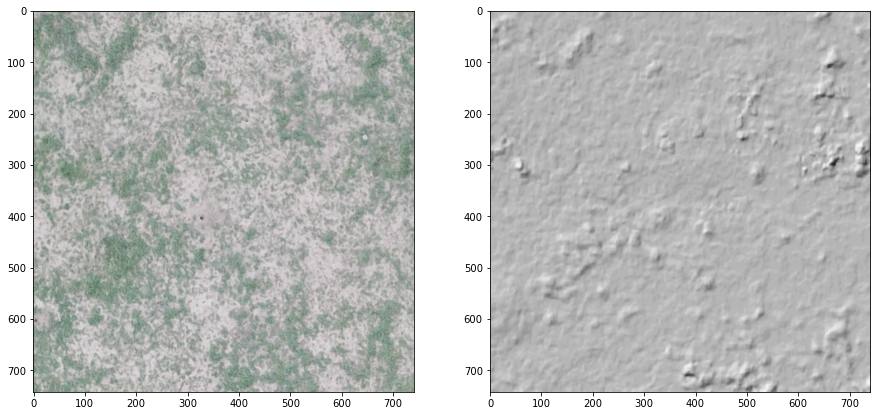

In [6]:
img_rgb = xr_rgb_crop.transpose('y', 'x', 'band').values
img_hillshade = xr_hillshade_crop.values.squeeze()
img_hillshade = skimage.transform.resize(img_hillshade, img_rgb.shape[:-1], preserve_range=True, anti_aliasing=True)
img_hillshade = skimage.color.gray2rgb(img_hillshade).astype('uint8')
img_overlay = cv.addWeighted(img_hillshade, 0.2, img_rgb, 0.8, 0)
plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.imshow(img_overlay, vmin=0, vmax=254, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_hillshade, vmin=0, vmax=254, cmap='gray')

In [7]:
741*2

1482

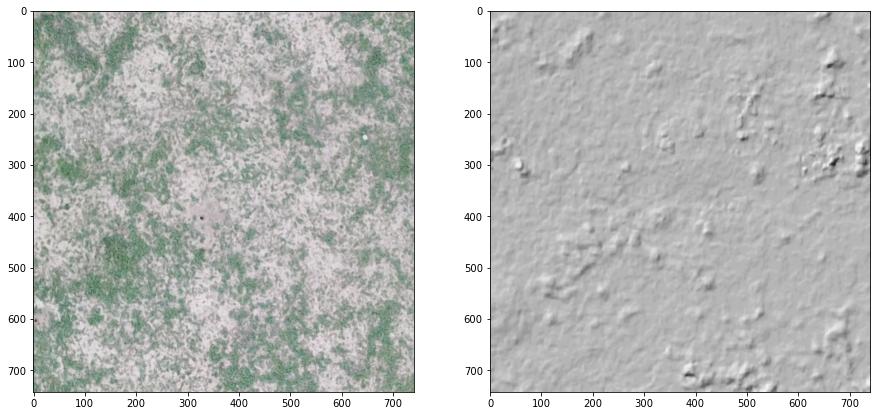

In [8]:
img_rgb = xr_rgb_crop.transpose('y', 'x', 'band').values
img_hillshade = xr_hillshade_crop.values.squeeze()
img_hillshade = skimage.transform.resize(img_hillshade, img_rgb.shape[:-1], preserve_range=True, anti_aliasing=True)
img_hillshade = skimage.color.gray2rgb(img_hillshade).astype('uint8')
img_overlay = cv.addWeighted(img_hillshade, 0.2, img_rgb, 0.8, 0)
plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb, vmin=0, vmax=254, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_hillshade, vmin=0, vmax=254, cmap='gray')

In [9]:
# ============================================================================
#FINAL_LINE_COLOR = (0, 0, 255)
#WORKING_LINE_COLOR = (0, 0, 126)
#FINAL_LINE_ALPHA = 0.35
#IMG1 = img_rgb
#IMG2 = img_hillshade

# ============================================================================

class PolygonDrawer(object, ):
    def __init__(self, img1, img2, window_name1, window_name2, 
                linecolor_final=(0, 0, 255), linecolor_working=(0, 0, 126), alpha=0.35):
        
        self.linecolor_final = linecolor_final
        self.linecolor_working = linecolor_working
        self.alpha = alpha

        self.window_name1 = window_name1 # Name for our window
        self.window_name2 = window_name2 # Name for our window
        self.img1 = img1
        self.img2 = img2
        
        self.done = False # Flag signalling we're done
        self.current = (0, 0) # Current position, so we can draw the line-in-progress
        self.points = [] # List of points defining our polygon
        self.polys = []


    def on_mouse(self, event, x, y, buttons, user_param):
        # Mouse callback that gets called for every mouse event (i.e. moving, clicking, etc.)

        if self.done: # Nothing more to do
            return

        if event == cv.EVENT_MOUSEMOVE:
            # We want to be able to draw the line-in-progress, so update current mouse position
            self.current = (x, y)
        elif event == cv.EVENT_LBUTTONDOWN:
            # Left click means adding a point at current position to the list of points
            print("Adding point #%d with position(%d,%d)" % (len(self.points), x, y))
            self.points.append((x, y))
        elif event == cv.EVENT_RBUTTONDOWN:
            # Right click means we're done
            print("Completing polygon with %d points." % len(self.points))
            self.polys.append(self.points)
            self.points = []
            canvas1 = self.img1.copy()
            output1 = canvas1.copy()
            canvas2 = self.img2.copy()
            output2 = canvas2.copy()
            if (len(self.polys) > 0):
                for p in self.polys:
                    cv.fillPoly(canvas1, np.array([p]), self.linecolor_final)
                    cv.fillPoly(canvas2, np.array([p]), self.linecolor_final)
            # And show it
            cv.addWeighted(canvas1, self.alpha, output1, 1 - self.alpha, 0, output1)
            cv.addWeighted(canvas2, self.alpha, output2, 1 - self.alpha, 0, output2)
            cv.imshow(self.window_name1, output1)
            cv.moveWindow(self.window_name1, 0, 0)
            cv.imshow(self.window_name2, output2)
            cv.moveWindow(self.window_name2, 800, 0)
            #self.done = True


    def run(self):
        # Let's create our working window and set a mouse callback to handle events
        cv.namedWindow(self.window_name1)
        cv.imshow(self.window_name1, self.img1)
        cv.moveWindow(self.window_name1, 0, 0)
        cv.waitKey(1)
        cv.setMouseCallback(self.window_name1, self.on_mouse)

        while(not self.done):
            # This is our drawing loop, we just continuously draw new images
            # and show them in the named window
            #canvas = np.zeros(CANVAS_SIZE, np.uint8)
            canvas1 = self.img1.copy()
            output1 = canvas1.copy()
            canvas2 = self.img2.copy()
            output2 = canvas2.copy()
            
            # Add any existing polygons
            if (len(self.polys) > 0):
                for p in self.polys:
                    cv.fillPoly(canvas1, np.array([p]), self.linecolor_final)
                    cv.fillPoly(canvas2, np.array([p]), self.linecolor_final)
            if (len(self.points) > 0):
                # Draw all the current polygon segments
                cv.polylines(canvas1, np.array([self.points]), False, self.linecolor_final, 2)
                cv.polylines(canvas2, np.array([self.points]), False, self.linecolor_final, 2)
                # And  also show what the current segment would look like
                cv.line(canvas1, self.points[-1], self.current, self.linecolor_working, 2)
                cv.line(canvas2, self.points[-1], self.current, self.linecolor_working, 2)

            # overlay polygons
            cv.addWeighted(canvas1, self.alpha, output1, 1 - self.alpha, 0, output1)
            cv.addWeighted(canvas2, self.alpha, output2, 1 - self.alpha, 0, output2)
            # draw mouse location on second image
            cv.circle(output2, self.current, radius=3, color=self.linecolor_final, thickness=-1)
            # Update the window
            cv.imshow(self.window_name1, output1)
            cv.moveWindow(self.window_name1, 0, 0)
            cv.imshow(self.window_name2, output2)
            cv.moveWindow(self.window_name2, 800, 0)
            # And wait 50ms before next iteration (this will pump window messages meanwhile)
            if cv.waitKey(50) == 8: # ESC hit
                self.points = []
            if cv.waitKey(50) == 27: # ESC hit
                self.done = True
            #if cv.waitKey(50) == 9: #TAB hit
            #    self.polys = self.polys.append(self.points)
            #    self.points = []

        # User finised entering the polygon points, so let's make the final drawing
        canvas_poly = np.zeros(canvas1.shape[:-1], np.uint8)
        # of a filled polygon
        if (len(self.polys) > 0):
            for p in self.polys:
                cv.fillPoly(canvas_poly, np.array([p]), (255, 255, 255))
        # Waiting for the user to press any key
        #cv.waitKey()
        #if cv.waitKey() == 27: # ESC hit
        cv.destroyWindow(self.window_name1)
        cv.destroyWindow(self.window_name2)
        
        return canvas_poly, self.polys

# ============================================================================

#if __name__ == "__main__":
    #pd = PolygonDrawer(img_rgb, img_hillshade, "Image1", "Image2")
    #image, polys = pd.run()
    #cv.imwrite("polygon.png", image)
    #print("Polygon = %s" % pd.points)

In [ ]:
df_out = pd.DataFrame(columns=['Tile_No', 'UL_Y', 'UL_X', 'num_objs', 'roi'])
idx = 0
for y_start, x_start in zip(y_starts_sub, x_starts_sub):
    print(y_start, x_start)
    xr_hillshade_crop = xr_hillshade.sel(y=slice(y_start, 
                                                 y_start - np.floor(
                                                     1/xr_hillshade.res[0]*window_size_m*xr_hillshade.res[0])), 
                                     x=slice(x_start,
                                             x_start + np.floor(
                                                 1/xr_hillshade.res[0]*window_size_m*xr_hillshade.res[1])))
    xr_rgb_crop = xr_rgb.sel(y=xr_rgb.y[(xr_rgb.y >= xr_hillshade_crop.y.min()) & (xr_rgb.y <= xr_hillshade_crop.y.max())],
               x=xr_rgb.x[(xr_rgb.x >= xr_hillshade_crop.x.min()) & (xr_rgb.x <= xr_hillshade_crop.x.max())])
    
    img_rgb = xr_rgb_crop.transpose('y', 'x', 'band').values
    img_hillshade = xr_hillshade_crop.values.squeeze()
    img_hillshade = skimage.transform.resize(img_hillshade, img_rgb.shape[:-1], preserve_range=True, anti_aliasing=True)
    img_hillshade = skimage.color.gray2rgb(img_hillshade).astype('uint8')
    
    if img_rgb.shape[0] != img_rgb.shape[1]:
        print('Skipping tile - overlaps edge (not square)')
        continue
    else:
        tool = PolygonDrawer(img_rgb, img_hillshade, "Image1", "Image2")
        image, polys = tool.run()
        df_out_tmp = pd.DataFrame({
            'Tile_No': idx,
            'UL_Y': y_start,
            'UL_X': x_start
        }, index=[idx])
        
        if len(polys) > 0:
            polygon = gpd.GeoDataFrame()
            for idx, p in enumerate(polys):
                p_coords = [(x_start + pi[0]*xr_rgb.res[0], y_start - pi[1]*xr_rgb.res[1]) for pi in p]
                polygon_geom=Polygon(p_coords)
                polygon = polygon.append(gpd.GeoDataFrame(index=[idx], 
                                                          crs=roi.crs, 
                                                          geometry=[polygon_geom]))
            polygon['Tile_No'] = df_out_tmp['Tile_No']
            polygon['UL_Y'] = df_out_tmp['UL_Y']
            polygon['UL_X'] = df_out_tmp['UL_X']
            polygon.crs = roi.crs
            polygon.to_file(filename='./polygons/polygons_tile_' + str(idx) + '.shp', 
                driver="ESRI Shapefile")
            df_out_tmp['num_objs'] = len(polygon)
        else:
            df_out_tmp['num_objs'] = 0
        df_out_tmp['roi'] = roi_f
        df_out = df_out.append(df_out_tmp)
        
        cv.imwrite('./tiles_annos/annotation_tile_' + str(idx) + '.png', image)
        cv.imwrite('./tiles_rgb/rgb_tile_' + str(idx) + '.png', img_rgb)
        cv.imwrite('./tiles_hillshade/hillshade_tile_' + str(idx) + '.png', img_hillshade)
        
        idx += 1

df_out.to_csv('training_metadata.csv')

4516646.4011104535 519880.6572879066
Adding point #0 with position(431,242)
Adding point #1 with position(365,242)
Adding point #2 with position(346,297)
Adding point #3 with position(383,345)
Adding point #4 with position(456,306)
Completing polygon with 5 points.
Adding point #0 with position(136,429)
Adding point #1 with position(79,456)
Adding point #2 with position(114,553)
Adding point #3 with position(182,523)
Adding point #4 with position(175,446)
Completing polygon with 5 points.
4516841.4011104535 519940.6572879066
Skipping tile - overlaps edge (not square)
4516961.4011104535 519850.6572879066
Adding point #0 with position(199,502)
Adding point #1 with position(150,518)
Adding point #2 with position(169,609)
Adding point #3 with position(228,548)
Completing polygon with 4 points.
4516856.4011104535 519850.6572879066
Skipping tile - overlaps edge (not square)
4516631.4011104535 519880.6572879066


In [19]:
xr_rgb_crop

<xarray.DataArray (band: 3, y: 742, x: 741)>
[1649466 values with dtype=uint8]
Coordinates:
  * band     (band) int32 1 2 3
  * y        (y) float64 4.517e+06 4.517e+06 4.517e+06 ... 4.517e+06 4.517e+06
  * x        (x) float64 5.2e+05 5.2e+05 5.2e+05 ... 5.2e+05 5.2e+05 5.2e+05
Attributes:
    transform:      (0.020190239060149065, 0.0, 519756.9299414974, 0.0, -0.02...
    crs:            +init=epsg:32613
    res:            (0.020190239060149065, 0.020190239060149065)
    is_tiled:       0
    nodatavals:     (nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    units:          ('metre', 'metre', 'metre', 'metre')
    AREA_OR_POINT:  Area

In [90]:
polygon

""


In [82]:
img_hillshade = np.repeat(xr_hillshade_crop.values.squeeze()[:, :, np.newaxis], 3, axis=2)
img_hillshade = skimage.transform.resize(img_hillshade, img_rgb.shape)
img_hillshade

array([[[0.6319077 , 0.6319077 , 0.6319077 ],
        [0.63283777, 0.63283777, 0.63283777],
        [0.63021364, 0.63021364, 0.63021364],
        ...,
        [0.73680667, 0.73680667, 0.73680667],
        [0.74725604, 0.74725604, 0.74725604],
        [0.74355246, 0.74355246, 0.74355246]],

       [[0.6269208 , 0.6269208 , 0.6269208 ],
        [0.62767266, 0.62767266, 0.62767266],
        [0.62555136, 0.62555136, 0.62555136],
        ...,
        [0.74013869, 0.74013869, 0.74013869],
        [0.75209654, 0.75209654, 0.75209654],
        [0.74785831, 0.74785831, 0.74785831]],

       [[0.64094644, 0.64094644, 0.64094644],
        [0.64219953, 0.64219953, 0.64219953],
        [0.63866403, 0.63866403, 0.63866403],
        ...,
        [0.73076739, 0.73076739, 0.73076739],
        [0.73848263, 0.73848263, 0.73848263],
        [0.73574811, 0.73574811, 0.73574811]],

       ...,

       [[0.66269239, 0.66269239, 0.66269239],
        [0.66682479, 0.66682479, 0.66682479],
        [0.65516551, 0